# Content

1. [Introduction](#1)
    * 1.1 [Context](#2)
    * 1.2 [Importance of Solubility in Drug Discovery](#3)
    * 1.3 [Original Model](#4)
2. [First Organization](#5)
    * 2.1 [Importing Libraries](#6)
    * 2.2 [Load Dataset](#7)
3. [Data Pre-processing](#8)
    * 3.1 [Train Dataset](#9)
        - 3.1.1 [Remove Missing Values](#10)
        - 3.1.2 [Remove Duplicate Values](#11)
    * 3.2 [Test Dataset](#12)
        - 3.2.1 [Remove Missing Values](#13)
        - 3.2.2 [Remove Duplicate Values](#14)
4. [Molecular Descriptors](#15)
    * 4.1 [Convert the molecules from the SMILES to an RDKit object](#17)

# 1. Introduction<a name =1 ></a>

## 1.1 Context <a name =2></a>

This project aims to compute a robust ML algorithm in order to predict the solubility of molecular architectures.

The inspiration to design this project came from the excellent blog entry by **Pat Walters**, which I link here.<sup><a href="#ref1">[1]</a></sup> The original paper, on which Walters based his blog entry was published in 2005 by Delany under the name of "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure".<sup><a href="#ref2">[2]</a></sup> The dataset was taken directly from the SI of the publication, and can be found here as `solubility_train_molecules.csv`. The test dataset was taken from the University of St. Andrews<sup><a href="#ref3">[3]</a></sup> and it is called here `solubility_test_molecules.csv`

## 1.2 Importance of Solubility in Drug Discovery <a name =3></a>

Solubility is the maximum amount of a substance that can dissolve in a particular solvent at a given temperature to form a homogeneous solution. It is a fundamental property that has profunds implications in most of the fields relevant to chemistry. The solubility of a substance can be influenced by factors such as its chemical structure, physicochemical properties, and interactions with the solvent.<sup><a href="#ref4">[4]</a></sup> Furthermore, it is not always a straightforward property. For example, the solubility of a substance in mixed solvents can deviate from simple rules, requiring specialized methods for accurate prediction.<sup><a href="#ref5">[5]</a></sup>

In drug discovery, solubility is crucial as it affects drug absorption and bioavailability. Poorly soluble drugs present challenges in drug formulation and delivery, and it might supposed a failed test during the drug design.<sup><a href="#ref6">[6]</a></sup> Poor aqueous solubility remains a primary challenge in drug discovery, necessitating innovative methods to address it.<sup><a href="#ref6">[7]</a></sup><sup><a href="#ref7">[8]</a></sup><sup><a href="#ref8">[9]</a></sup><sup><a href="#ref9">[10]</a></sup>

## 1.3 Original Model <a name =4></a>

The equation presented in the original publication is represented here:

$$ LogS = 0.16 -  0.63 cLogP - 0.0062 MW + 0.066 RB - 0.74 AP $$

- **LogS** = log of the aqueous solubility
- **cLogP** = octanol-water partition coefficient
- **MW** = molecular weight
- **RB** = number of rotatable bonds
- **AP** = number of rotatable bonds and AP is the aromatic proportion (number of aromatic atoms / total number of heavy atoms).

Considering this features in the equation, RDKit will be implemented in order to extract these previously listed descriptors.

# 2 First Organization<a name = 5></a>

## 2.1 Importing Libraries<a name =6></a>

In [1]:
! pip install rdkit

In [2]:
! pip install mols2grid

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Descriptors import MolWt, NumRotatableBonds
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem import PandasTools #Add the ability to add a molecule to a dataframe
import mols2grid #The mols2grid library provides a convenient way of displaying molecules in a grid

## 2.2 Load Dataset<a name = 7></a>

In [4]:
df_train = pd.read_csv('solubility_train_molecules.csv')

In [5]:
df_train.shape

(1144, 4)

In [6]:
df_train.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


The dataset contains the following columns:

- Compound ID: An identifier for the chemical compound.
- InChIKey: A unique string identifier for chemical substances.
- SMILES: The Simplified Molecular Input Line Entry System notation, which is a way to represent a chemical structure as a text string.
- logS: The logarithm of the solubility of the compound, which is our target variable.
- logP: The logarithm of the partition coefficient of the compound between octanol and water. This is an important descriptor in drug discovery as it gives insight into the lipophilicity of a molecule.
- MW: Molecular weight of the compound.

In [7]:
df_test = pd.read_csv('solubility_test_molecules.csv')

In [8]:
df_test.shape

(100, 3)

In [9]:
df_test.head()

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,O=C(Nc1ccccc1)C,-1.40
1,Adenosine,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,-1.73
2,Allopurinol,c1c2c([nH]n1)ncnc2O,-2.26
3,Trimethoprim,COc1cc(cc(c1OC)OC)Cc2cnc(nc2N)N,-2.95
4,Acetazolamide,O=S(=O)(c1nnc(s1)NC(=O)C)N,-2.44


# 3. Data Pre-processing<a name = 8></a>

## 3.1 Train Dataset<a name = 9></a>

### 3.1.1 Remove Missing Values<a name = 10></a>

In [10]:
# Check for missing values in the dataset
missing_values = df_train.SMILES.isnull().sum()

missing_values

0

### 3.1.2 Remove Duplicate Values<a name = 12></a>

In [11]:
# generate canonical SMILES
def canonical_SMILES(smiles):
    canon_smiles = [Chem.CanonSmiles(smi) for smi in smiles]
    return canon_smiles

In [12]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(df_train.SMILES)

# Replace SMILES column with Canonical SMILES
df_train["SMILES"] = canon_smiles

In [13]:
# Create a list for duplicate smiles
duplicate_smiles = df_train[df_train['SMILES'].duplicated()]['SMILES'].values
duplicate_smiles

array(['Clc1ccc(-c2cccc(Cl)c2Cl)cc1', 'Clc1ccc(-c2cc(Cl)ccc2Cl)cc1',
       'Clc1ccc(-c2ccccc2Cl)cc1', 'Brc1ccc2ccccc2c1', 'CCC(C)CCO',
       'CCC1(CCC(C)C)C(=O)NC(=O)NC1=O', 'Cc1ccc(NC(=O)N(C)C)cc1Cl',
       'CCOP(=S)(OCC)SC(CCl)N1C(=O)c2ccccc2C1=O',
       'ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl',
       'CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O',
       'CCOC1Oc2ccc(OS(C)(=O)=O)cc2C1(C)C', 'CCOC(=O)c1ccc(N)cc1',
       'CC12CCC(CC1)C(C)(C)O2', 'CN(C)C(=O)Nc1cccc(C(F)(F)F)c1',
       'OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O',
       'Cc1ncc([N+](=O)[O-])n1CCO',
       'CCN(CC)c1c([N+](=O)[O-])cc(C(F)(F)F)c(N)c1[N+](=O)[O-]',
       'COc1ccccc1O', 'Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)Cl)cc1',
       'ClC(Cl)=C(c1ccc(Cl)cc1)c1ccc(Cl)cc1', 'Nc1ccc(-c2ccc(N)cc2)cc1',
       'CCC1(c2ccccc2)C(=O)NC(=O)NC1=O', 'CCC1(C(C)C)C(=O)NC(=O)NC1=O',
       'O=C1c2ccccc2Cc2ccccc2N1CCF', 'NC(=O)c1ccccc1O',
       'OCC(O)C(O)C(O)C(O)CO',
       'NS(=O)(=O)c1cc2c(cc1Cl)NC(C(Cl)Cl)NS2(=O)=O'], dtype=object)

In [14]:
# filter the duplicate smiles and sort them based on smiles
df_train[df_train['SMILES'].isin(duplicate_smiles)].sort_values(by=['SMILES'])

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
192,2-Bromonapthalene,-4.400,-4.434,Brc1ccc2ccccc2c1
191,2-bromonaphthalene,-4.400,-4.434,Brc1ccc2ccccc2c1
55,"1,8-Cineole",-1.740,-2.579,CC12CCC(CC1)C(C)(C)O2
674,eucalyptol,-1.640,-2.579,CC12CCC(CC1)C(C)(C)O2
392,Androsterone,-4.402,-3.882,CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O
629,Epiandrosterone,-4.160,-3.882,CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O
288,3-Methyl-2-pentanol,-0.720,-1.381,CCC(C)CCO
289,3-Methyl-2-pentanol,-0.710,-1.308,CCC(C)CCO
338,5-Ethyl-5-isopropylbarbituric acid,-2.148,-1.603,CCC1(C(C)C)C(=O)NC(=O)NC1=O
981,probarbital,-2.210,-1.603,CCC1(C(C)C)C(=O)NC(=O)NC1=O


In [15]:
# Drop rows that contain duplicate SMILES and keep the first Structure
df_train_no_dup = df_train.drop_duplicates(subset=['SMILES'], keep='first')

In [16]:
df_train_no_dup.shape

(1117, 4)

## 3.2 Test Dataset<a name = 13></a>

### 3.2.1 Remove Missing Values<a name = 14></a>

In [17]:
# Check for missing values in the dataset
missing_values_test = df_test.SMILES.isnull().sum()

missing_values_test

0

### 3.2.2 Remove Duplicates Values<a name = 15></a>

In [18]:
# Generate canonical Smiles
canon_smiles_test = canonical_SMILES(df_test.SMILES)

# Replace SMILES column with Canonical SMILES
df_test["SMILES"] = canon_smiles_test

In [19]:
# Create a list for duplicate smiles
duplicate_smiles_test = df_test[df_test['SMILES'].duplicated()]['SMILES'].values
duplicate_smiles_test

array([], dtype=object)

In [20]:
len(duplicate_smiles_test)

0

In [21]:
# Check if we have the same molecules in the train and test dataset
overlapping_molecules = df_train_no_dup[df_train_no_dup['SMILES'].isin(df_test['SMILES'])]

In [22]:
print(f"There are {overlapping_molecules.shape[0]} overlapping molecules.")
print(overlapping_molecules)

There are 35 overlapping molecules.
                   Compound ID  measured log(solubility:mol/L)  \
31      1,3,5-Trichlorobenzene                          -4.480   
98                   1-Napthol                          -2.220   
339   5-Ethyl-5-phenylbarbital                          -2.322   
340             5-fluorouracil                          -1.077   
362                Acetanilide                          -1.330   
363              acetazolamide                          -2.360   
399                 Antipyrene                           0.715   
416                  Benzamide                          -0.960   
553                    Dapsone                          -3.094   
570                   Diazepam                          -3.754   
622                     Diuron                          -3.800   
685                fluconazole                          -1.800   
691                Fluometuron                          -3.430   
714                    guanine          

In [23]:
# Search structures that are present in the test set from training set
overlapping_smiles = df_train_no_dup[df_train_no_dup['SMILES'].isin(df_test['SMILES'])]['SMILES']
overlapping_smiles

31                       Clc1cc(Cl)cc(Cl)c1
98                          Oc1cccc2ccccc12
339          CCC1(c2ccccc2)C(=O)NC(=O)NC1=O
340                 O=c1[nH]cc(F)c(=O)[nH]1
362                         CC(=O)Nc1ccccc1
363              CC(=O)Nc1nnc(S(N)(=O)=O)s1
399                Cc1cc(=O)n(-c2ccccc2)n1C
416                          NC(=O)c1ccccc1
553         Nc1ccc(S(=O)(=O)c2ccc(N)cc2)cc1
570     CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21
622             CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1
685      OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F
691           CN(C)C(=O)Nc1cccc(C(F)(F)F)c1
714                Nc1nc2[nH]cnc2c(=O)[nH]1
730      NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O
765              CC(C)c1ccc(NC(=O)N(C)C)cc1
770        COc1c2occc2c(OC)c2c(=O)cc(C)oc12
776            CON(C)C(=O)Nc1ccc(Cl)c(Cl)c1
838               Cc1ncc([N+](=O)[O-])n1CCO
895                         NC(=O)c1ccccc1O
939      c1cc2cccc3c4cccc5cccc(c(c1)c23)c54
941                    CCOc1ccc(NC(C)=O)cc1
954       O=C1NC(=O)C(c2ccccc2)(

In [24]:
# Exclude structures that are present in the test set from training set
train_data_clean = df_train_no_dup[~df_train_no_dup['SMILES'].isin(overlapping_smiles)] # ~ inverse booleans.
                                                                                        # Selecting rows where the 'SMILES' value is NOT in overlapping_smiles.

In [25]:
train_data_clean.shape

(1082, 4)

In [26]:
# Filter the rows where the SMILES string contains the '.' character
multi_molecule_rows = train_data_clean[train_data_clean['SMILES'].str.contains('\.')]

# Count and display the rows that contain more than one molecule
num_multi_molecule = multi_molecule_rows.shape[0]
sample_multi_molecule = multi_molecule_rows.head()

num_multi_molecule, sample_multi_molecule

(0,
 Empty DataFrame
 Columns: [Compound ID, measured log(solubility:mol/L), ESOL predicted log(solubility:mol/L), SMILES]
 Index: [])

**The result indicates that there are no SMILES strings in the dataset that represent more than one molecule.**

In [27]:
train_data_clean.to_csv('solubility_train_clean.csv')

# 4. Molecular Descriptors<a name = 16></a>

## 4.1 Convert the molecule from SMILES to an RDKit object<a name = 17></a>

RDKit function **Chem.MolFromSmiles** to covert a SMILES to a molecule object that can be depicted

In [28]:
mol_list = [Chem.MolFromSmiles(element) for element in train_data_clean.SMILES]

In [29]:
mol_list[:5]

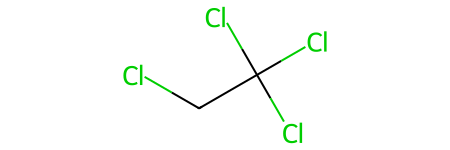

In [30]:
Chem.MolFromSmiles(train_data_clean['SMILES'].iloc[0])

## 4.2 Add the MW, LogP and RB descriptors<a name = 18></a>

In [31]:
# Creat a DataFrame from the mol_list
df_mol_list = pd.DataFrame(mol_list, columns=['Molecule'])

In [32]:
df_mol_list.head()

,Molecule
0,<rdkit.Chem.rdchem.Mol object at 0x7fa2815ffae0>
1,<rdkit.Chem.rdchem.Mol object at 0x7fa2815fe6c0>
2,<rdkit.Chem.rdchem.Mol object at 0x7fa2815fcc10>
3,<rdkit.Chem.rdchem.Mol object at 0x7fa2815fcd60>
4,<rdkit.Chem.rdchem.Mol object at 0x7fa2815fcf20>


In [33]:
# Add MW, LogP and NumRotatableBonds
df_mol_list['MW'] = [MolWt(x) for x in df_mol_list.Molecule]
df_mol_list['LogP'] = [MolLogP(x) for x in df_mol_list.Molecule]
df_mol_list['NumRotableBonds'] = [NumRotatableBonds(x) for x in df_mol_list.Molecule]

In [34]:
df_mol_list.head()

,Molecule,MW,LogP,NumRotableBonds
0,<rdkit.Chem.rdchem.Mol object at 0x7fa2815ffae0>,167.850,2.5954,0
1,<rdkit.Chem.rdchem.Mol object at 0x7fa2815fe6c0>,133.405,2.3765,0
2,<rdkit.Chem.rdchem.Mol object at 0x7fa2815fcc10>,167.850,2.5938,1
3,<rdkit.Chem.rdchem.Mol object at 0x7fa2815fcd60>,133.405,2.0289,1
4,<rdkit.Chem.rdchem.Mol object at 0x7fa2815fcf20>,187.375,2.9189,1


In [35]:
df_mol_list.shape

(1082, 4)

In [36]:
# Visualize the DataFrame of the molecules within a grid
two_decimals = lambda x: f"{x:.2f}"
mols2grid.display(df_mol_list,mol_col="Molecule",subset=["img","MW","LogP","NumRotableBonds"],transform={"MW" : two_decimals, "LogP": two_decimals})

MolGridWidget()

In [37]:
df_mol_list.to_csv('rdkit_molecular_descriptors_MW_LogP_NumRotatableBonds.csv')

## 4.3 Add Aromatic Portion<a name = 19></a>

In [38]:
def aromatic_portion(smiles):
    mol = Chem.MolFromSmiles(smiles)
    num_aromatic_atoms = sum([atom.GetIsAromatic() for atom in mol.GetAtoms()])
    total_atoms = mol.GetNumAtoms()
    return num_aromatic_atoms / total_atoms if total_atoms > 0 else 0

In [39]:
train_data_clean = train_data_clean.copy()
train_data_clean['aromatic_portion'] = train_data_clean['SMILES'].apply(aromatic_portion)

In [40]:
train_data_clean

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES,aromatic_portion
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl,0.000000
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl,0.000000
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl,0.000000
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl,0.000000
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl,0.000000
...,...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)OC,0.000000
1140,Vinclozolin,-4.925,-4.377,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,0.333333
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,0.695652
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,0.521739


## 4.3 Combining the Descriptors<a name = 20></a>

In [41]:
train_data_clean.drop(train_data_clean.columns[:-1], axis=1, inplace=True)

In [42]:
train_data_clean.reset_index(drop=True, inplace=True)

In [43]:
train_data_clean.to_csv('aromatic_rotation.csv')

In [44]:
train_data_clean

,aromatic_portion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1077,0.000000
1078,0.333333
1079,0.695652
1080,0.521739


In [45]:
df_mol_list.drop(df_mol_list.columns[0], axis=1, inplace=True)

In [46]:
df_mol_list

,MW,LogP,NumRotableBonds
0,167.850,2.59540,0
1,133.405,2.37650,0
2,167.850,2.59380,1
3,133.405,2.02890,1
4,187.375,2.91890,1
...,...,...,...
1077,287.343,1.98820,8
1078,286.114,3.42130,2
1079,308.333,3.60960,4
1080,354.815,2.56214,3


In [47]:
df_mol_list.to_csv('MW_LogP_RB.csv')

In [48]:
molecular_descriptors = pd.concat([df_mol_list,train_data_clean], axis=1)

In [49]:
molecular_descriptors

,MW,LogP,NumRotableBonds,aromatic_portion
0,167.850,2.59540,0,0.000000
1,133.405,2.37650,0,0.000000
2,167.850,2.59380,1,0.000000
3,133.405,2.02890,1,0.000000
4,187.375,2.91890,1,0.000000
...,...,...,...,...
1077,287.343,1.98820,8,0.000000
1078,286.114,3.42130,2,0.333333
1079,308.333,3.60960,4,0.695652
1080,354.815,2.56214,3,0.521739


In [50]:
molecular_descriptors.to_csv('molecular_descriptors.csv')

# References

<ol>
        <li id="ref1"><a href="https://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html" target="_blank"> Predicting Aqueous Solubility - It's Harder Than It Looks</a></li>
        <li id="ref2"><a href="https://doi.org/10.1021/ci034243x" target="_blank">J. Chem. Inf. Comput. Sci. 2004, 44, 3, 1000–1005. "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure". John S. Delaney. Publication Date: March 13, 2004. Copyright © 2004 American Chemical Society.</a></li>
        <li id="ref3"><a href="https://risweb.st-andrews.ac.uk/portal/en/datasets/dls100-solubility-dataset(3a3a5abc-8458-4924-8e6c-b804347605e8).html" target="_blank"> DLS-100 Solubility Dataset</a></li>
        <li id="ref4"><a href="https://doi.org/10.1016/J.GCA.2006.06.011" target="_blank">Geochimica et Cosmochimica Acta, 2006, 70, 3820-3829. "Relationship between solubility and solubility product: The roles of crystal sizes and crystallographic directions". Fan, C., Chen, J., Chen, Y., Ji, J., & Teng, H.</a></li>
        <li id="ref5"><a href="https://doi.org/10.1002/AIC.11759" target="_blank">Aiche Journal, 2009, 55, 1256-1264. "Method for predicting solubilities of solids in mixed solvents". Ellegaard, M., Abildskov, J., & O’Connell, J.</a></li>
        <li id="ref6"><a href="https://doi.org/10.1021/acs.molpharmaceut.5b00111" target="_blank">Molecular pharmaceutics, 2015, 12(10), 3535-46. "Cocrystal Transition Points: Role of Cocrystal Solubility, Drug Solubility, and Solubilizing Agents.". Lipert, M., & Rodríguez-Hornedo, N.</a></li>
        <li id="ref7"><a href="https://doi.org/10.1517/17460441.2014.960839" target="_blank">Expert Opinion on Drug Discovery, 2014, 9, 1421-1433. "Novel tactics for designing water-soluble molecules in drug discovery". Walker, M.</a></li>
        <li id="ref8"><a href="https://doi.org/10.1016/J.MOLLIQ.2009.02.003" target="_blank">Journal of Molecular Liquids, 2009, 146, 82-88. "Prediction of drug solubility in mixed solvents using computed Abraham parameters". Jouyban, A., Soltanpour, S., Soltani, S., Tamizi, E., Fakhree, M., & Acree, W.</a></li>
        <li id="ref9"><a href="https://doi.org/10.5599/ADMET.3.4.259" target="_blank">ADMET and DMPK, 2015, 3, 298-344. "Solubility Temperature Dependence Predicted from 2D Structure". Avdeef, A.</a></li>
        <li id="ref10"><a href="https://doi.org/10.1021/acs.molpharmaceut.9b01138" target="_blank">Molecular pharmaceutics, 2020. "Guiding Lead Optimization for Solubility Improvement with Physics-based Modeling.". Abramov, Y., Sun, G., Zeng, Q., Zeng, Q., & Yang, M.</a></li>

</ol>